In [1]:
import numpy as np
import pandas as pd
import time

from sklearn.datasets import fetch_covtype
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 16

In [2]:
covtype = fetch_covtype()
y = covtype.target

pd.Series(y).value_counts(sort=False)

1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
dtype: int64

In [3]:
# Multiclass to Binary
X = covtype.data[y < 3]
y = y[y < 3] - 1
print(X.shape, y.mean())

(495141, 54) 0.572162272969


In [4]:
idx = np.arange(y.size)
np.random.seed(1234)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [5]:
feature_names = ['f%02d' % i for i in range(X.shape[1])]
xgmat_train = xgb.DMatrix(X[:100000], label=y[:100000], feature_names=feature_names)
xgmat_valid = xgb.DMatrix(X[-100000:], label=y[-100000:], feature_names=feature_names)

watchlist = [(xgmat_train,'train'), (xgmat_valid, 'valid')]

In [6]:
params_xgb = {'objective':'binary:logistic',
              'eta':0.2,
              'max_depth':10,
              'eval_metric':'logloss',
              'seed':2017,
              'silent':True}
n_rounds = 100

In [7]:
evals_result = {}
t0 = time.time()
print("Training ...")
bst = xgb.train(params_xgb, xgmat_train, n_rounds, watchlist,
                evals_result=evals_result, verbose_eval=False)
print("Done: %.1fs" % (time.time() - t0))

Training ...
Done: 7.0s


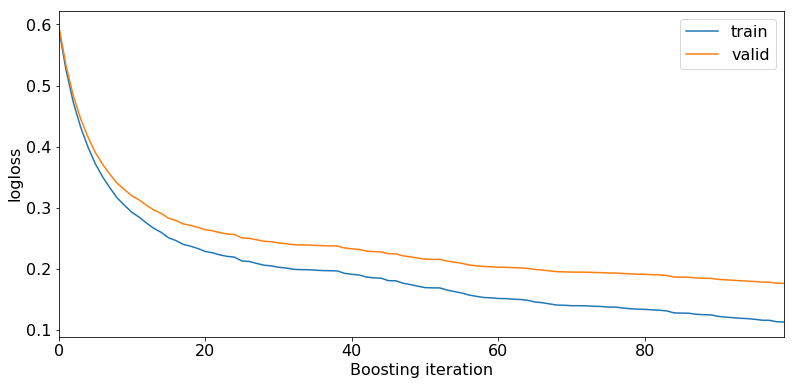

In [8]:
df_score = pd.DataFrame({'train':evals_result['train']['logloss'],
                         'valid':evals_result['valid']['logloss']})
df_score.plot(figsize=(13, 6))
plt.ylabel("logloss")
plt.xlabel("Boosting iteration")

In [9]:
params_xgb.update({'process_type':'update',
                   'updater':'refresh',
                   'refresh_leaf': False})

In [10]:
t0 = time.time()
print("Refreshing ...")
bst_after = xgb.train(params_xgb, xgmat_valid, n_rounds, xgb_model=bst)
print("Done: %.1fs" % (time.time() - t0))

Refreshing ...
Done: 0.6s


In [11]:
imp_2 = pd.DataFrame(index=xgmat_train.feature_names)
imp_2['train'] = pd.Series(bst.get_score(importance_type='gain'))
imp_2['after_refresh'] = pd.Series(bst_after.get_score(importance_type='gain'))
imp_2 = imp_2.dropna()
imp_2 /= imp_2.sum(0)*.01
imp_2 = imp_2.sort_values('train')
print(imp_2.tail())

        train  after_refresh
f36  3.774738       3.721348
f44  3.814734       3.956078
f45  5.003247       4.501594
f35  6.052359       7.055316
f00  6.296838       5.977178


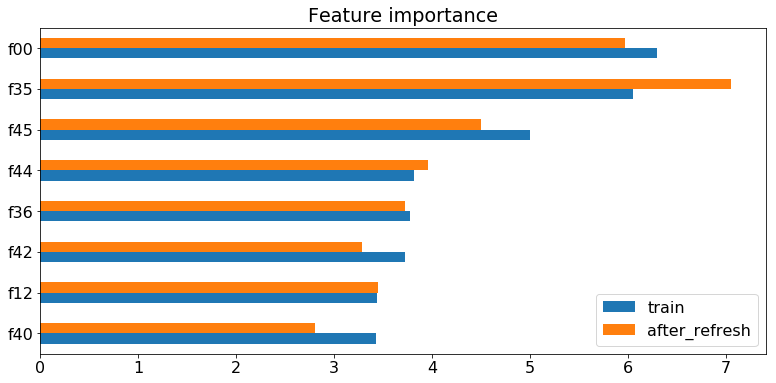

In [12]:
imp_2.tail(8).plot(kind='barh', title="Feature importance", figsize=(13, 6))